# Laboratorio 6 Parte 1

En este laboratorio, estaremos repasando los conceptos de Generative Adversarial Networks En la primera parte nos acercaremos a esta arquitectura a través de buscar aproximar una función. Esta vez ya no usaremos versiones deprecadas de la librería de PyTorch, por ende, creen un nuevo virtual env con las librerías más recientes que puedan por favor.

Al igual que en laboratorios anteriores, para este laboratorio estaremos usando una herramienta para Jupyter Notebooks que facilitará la calificación, no solo asegurándo que ustedes tengan una nota pronto sino también mostrandoles su nota final al terminar el laboratorio.

De nuevo me discupo si algo no sale bien, seguiremos mejorando conforme vayamos iterando. Siempre pido su comprensión y colaboración si algo no funciona como debería. 

Al igual que en el laboratorio pasado, estaremos usando la librería de Dr John Williamson et al de la University of Glasgow, además de ciertas piezas de código de Dr Bjorn Jensen de su curso de Introduction to Data Science and System de la University of Glasgow para la visualización de sus calificaciones. 

**NOTA:** Ahora tambien hay una tercera dependecia que se necesita instalar. Ver la celda de abajo por favor

<script type="text/javascript" src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML">
</script>

In [1]:
# Una vez instalada la librería por favor, recuerden volverla a comentar.
#!pip install -U --force-reinstall --no-cache https://github.com/johnhw/jhwutils/zipball/master
#!pip install scikit-image
#!pip install -U --force-reinstall --no-cache https://github.com/AlbertS789/lautils/zipball/master

In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy
from PIL import Image
import os
from collections import defaultdict

#from IPython import display
#from base64 import b64decode


# Other imports
from unittest.mock import patch
from uuid import getnode as get_mac

from jhwutils.checkarr import array_hash, check_hash, check_scalar, check_string, array_hash, _check_scalar
import jhwutils.image_audio as ia
import jhwutils.tick as tick
from lautils.gradeutils import new_representation, hex_to_float, compare_numbers, compare_lists_by_percentage, calculate_coincidences_percentage

###
tick.reset_marks()

%matplotlib inline

In [3]:
# Celda escondida para utlidades necesarias, por favor NO edite esta celda


###### Información del estudiante en dos variables

* carne_1 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_1: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)
* carne_2 : un string con su carne (e.g. "12281"), debe ser de al menos 5 caracteres.
* firma_mecanografiada_2: un string con su nombre (e.g. "Albero Suriano") que se usará para la declaracion que este trabajo es propio (es decir, no hay plagio)

In [4]:
carne_1 = '21752'
firma_mecanografiada_1 = 'Diego Leiva'
carne_2 = '21970'
firma_mecanografiada_2 = 'Pablo Orellana'

In [5]:
# Deberia poder ver dos checkmarks verdes [0 marks], que indican que su información básica está OK 

with tick.marks(0): 
    assert(len(carne_1)>=5 and len(carne_2)>=5)

with tick.marks(0):  
    assert(len(firma_mecanografiada_1)>0 and len(firma_mecanografiada_2)>0)

### Introducción

**Créditos:** Esta parte de este laboratorio está tomado y basado en uno de los blogs de Renato Candido, así como las imagenes presentadas en este laboratorio a menos que se indique lo contrario.

Los Generative Adversarial Networks representan sistemas de aprendizaje automático capaces de aprender a imitar una distribución específica de datos. Estos fueron propuestos por primera vez en un artículo de NeurIPS en 2014 por Ian Goodfellow, un experto en el campo del aprendizaje profundo, y sus colegas.

Las GAN consisten en dos redes neuronales, una de las cuales se entrena para generar datos, mientras que la otra se entrena para discernir entre datos falsos y auténticos (de ahí proviene la naturaleza "adversarial" del modelo). Aunque la noción de una estructura destinada a la generación de datos no es novedosa, en lo que respecta a la creación de imágenes y videos, las GAN han arrojado resultados sorprendentes,

Architecturas que producen datos, como las GAN, se clasifican como modelos generativos en contraste con los modelos discriminatorios, que son más ampliamente estudiados. Antes de adentrarnos en las GAN, exploraremos las diferencias entre estos dos tipos de modelos.

La mayoría de las aplicaciones con las que te hemos trabajado hasta ahora han sido implementaciones usando modelos discriminatorios. Por otro lado, las redes generativas adversarias pertenecen a una categoría diferente de modelos conocidos como modelos generativos.

Los modelos discriminatorios son aquellos que se utilizan para la mayoría de los problemas de clasificación o regresión supervisada. Como ejemplo de un problema de clasificación, supongamos que deseamos entrenar un modelo para clasificar imágenes de dígitos escritos a mano del 0 al 9 (un ejemplo bastante común). Para esto, podríamos usar un conjunto de datos etiquetado que contenga imágenes de dígitos escritos a mano y sus etiquetas asociadas que indican qué dígito representa cada imagen.

Durante el proceso de entrenamiento, utilizaríamos un algoritmo para ajustar los parámetros del modelo. El objetivo sería minimizar una función de pérdida para que el modelo aprenda la **distribución de probabilidad** de la salida dada la entrada. Después de la fase de entrenamiento, podríamos utilizar el modelo para clasificar una nueva imagen de un dígito escrito a mano estimando el dígito más probable al que corresponde la entrada según lo aprendindo durante la fase de entrenamiento.

![](https://files.realpython.com/media/fig_discriminative.9c22a1cd877d.png)

Los modelos discriminativos para problemas de clasificación pueden ser visualizados como bloques que utilizan los datos de entrenamiento para aprender los límites entre las clases. Luego, utilizan estos límites para discriminar una entrada y predecir su clase. En términos matemáticos, los modelos discriminativos aprenden la probabilidad condicional P(y|x) de la salida "y" dada la entrada "x".

Además de las redes neuronales, otras estructuras pueden ser utilizadas como modelos discriminativos, como modelos de regresión logística y máquinas de soporte vectorial (SVM).

Por otro lado, los modelos generativos como las GANs se entrenan para describir cómo se genera un conjunto de datos en términos de un modelo probabilístico. Al muestrear de un modelo generativo, podemos generar nuevos datos. Mientras que los modelos discriminativos se utilizan para el aprendizaje supervisado, los modelos generativos a menudo se emplean con conjuntos de datos no etiquetados y pueden considerarse como una forma de aprendizaje no supervisado.

Utilizando el conjunto de datos de dígitos escritos a mano, podríamos entrenar un modelo generativo para generar nuevos dígitos. Durante la fase de entrenamiento, utilizaríamos algún algoritmo para ajustar los parámetros del modelo y minimizar una función de pérdida para aprender la distribución de probabilidad del conjunto de entrenamiento. Luego, con el modelo entrenado, podríamos generar nuevas muestras.

![](https://files.realpython.com/media/fig_generative.5f01c08f5208.png)


Para producir nuevas muestras, los modelos generativos suelen incorporar un elemento **estocástico** o aleatorio que influye en las muestras generadas por el modelo. Las muestras aleatorias utilizadas para impulsar el generador se obtienen de un **espacio latente** en el que los vectores representan una especie de forma comprimida de las muestras generadas.

A diferencia de los modelos discriminativos, los modelos generativos aprenden la probabilidad P(x) de los datos de entrada "x", y al tener la distribución de los datos de entrada, pueden generar nuevas instancias de datos.

Vale la pena mencionar que los modelos generativos también pueden ser utilizados con conjuntos de datos etiquetados. Cuando lo son, se entrenan para aprender la probabilidad P(x|y) de la entrada "x" dado el resultado "y". También pueden ser utilizados para tareas de clasificación, pero en general, los modelos discriminativos tienen un mejor rendimiento en lo que respecta a la clasificación.


### Sobre la Arquitectura

Las redes Generativas Adversarias están compuestas por una estructura global que consta de dos redes neuronales, una llamada generador y otra llamada discriminador.

El papel del generador es estimar la distribución de probabilidad de las muestras reales para proporcionar muestras generadas que se asemejen a datos reales. El discriminador, a su vez, se entrena para estimar la probabilidad de que una muestra dada provenga de los datos reales en lugar de ser proporcionada por el generador.

Estas estructuras se llaman redes generativas adversarias porque el generador y el discriminador se entrenan para competir entre sí: el generador intenta mejorar engañando al discriminador, mientras que el discriminador intenta mejorar identificando muestras generadas.

Para comprender cómo funciona el entrenamiento de las GAN, vamos a considerar un ejemplo sencillo con un conjunto de datos compuesto por muestras bidimensionales (x₁, x₂), donde x₁ está en el intervalo de 0 a 2π y x₂ = sin(x₁). Una función que se puede visualizar como la siguiente imagen:

![](https://files.realpython.com/media/fig_x1x2.f8a39d8ff58a.png)

Como se puede ver, este conjunto de datos consiste en puntos (x₁, x₂) ubicados sobre una curva senoidal, que tiene una distribución muy particular. La estructura general de una GAN para generar pares (x̃₁, x̃₂) que se asemejen a las muestras del conjunto de datos se muestra en la siguiente figura:

![](https://files.realpython.com/media/fig_gan.4f0f744c7999.png)

El generador G recibe datos aleatorios de un espacio latente, y su función es generar datos que se parezcan a las muestras reales. En este ejemplo, se tiene un espacio latente bidimensional, de manera que el generador recibe pares aleatorios (z₁, z₂) y debe transformarlos de manera que se asemejen a las muestras reales.

La estructura de la red neuronal G puede ser arbitraria, lo que te permite utilizar redes neuronales como multi-layer perceptron (MLP), redes neuronales convolucionales (CNN) o cualquier otra estructura, **siempre que las dimensiones de la entrada y la salida coincidan con las dimensiones del espacio latente y los datos reales.**

El discriminador D recibe muestras reales del conjunto de datos de entrenamiento o muestras generadas proporcionadas por G. Su función es estimar la probabilidad de que la entrada pertenezca al conjunto de datos reales. El entrenamiento se realiza de manera que D emita un 1 cuando se le proporciona una muestra real y un 0 cuando se le proporciona una muestra generada.

Al igual que con G, se puede elegir una estructura de red neuronal arbitraria para D, siempre que respete las dimensiones necesarias de entrada y salida. En esta primera parte, la entrada es bidimensional. Para un discriminador binario, la salida puede ser un escalar que varía entre 0 y 1.

El proceso de entrenamiento de GAN consiste en un juego minimax (¿les suena o recuerdan este concepto?) de dos jugadores en el que D se adapta para minimizar el error de discriminación entre muestras reales y generadas, y G se adapta para maximizar la probabilidad de que D cometa un error.

Aunque el conjunto de datos que contiene los datos reales no está etiquetado, los procesos de entrenamiento para D y G se realizan de manera supervisada. En cada paso del entrenamiento, los parámetros de D y G se actualizan. De hecho, en la propuesta original de las GAN, los parámetros de D se actualizan k veces, mientras que los parámetros de G se actualizan solo una vez en cada paso de entrenamiento. Sin embargo, para simplificar el entrenamiento, se puede considerar k igual a 1.

Para entrenar a D, en cada iteración se etiquetan algunas muestras reales tomadas de los datos de entrenamiento como 1 y algunas muestras generadas proporcionadas por G como 0. De esta manera, puedes utilizar un marco de entrenamiento supervisado convencional para actualizar los parámetros de D con el fin de minimizar una función de pérdida, como se muestra en el siguiente esquema:

![](https://files.realpython.com/media/fig_train_discriminator.cd1a1e32764f.png)

Para cada batch de datos de entrenamiento que contiene muestras reales y generadas, se actualizan los parámetros de D para minimizar una función de pérdida. Después de actualizar los parámetros de D, se entrena a G para producir mejores muestras generadas. La salida de G está conectada a D, cuyos parámetros se mantienen congelados, como se muestra aquí:

![](https://files.realpython.com/media/fig_train_generator.7196c4f382ba.png)

Se puede imaginar el sistema compuesto por G y D como un sistema de clasificación único que recibe muestras aleatorias como entrada y produce la clasificación, que en este caso puede interpretarse como una probabilidad.

Cuando G hace un trabajo lo suficientemente bueno como para engañar a D, la probabilidad de salida debería estar cerca de 1. También se podría utilizar un framework de entrenamiento supervisado convencional aquí: el conjunto de datos para entrenar el sistema de clasificación compuesto por G y D sería proporcionado por muestras de entrada aleatorias, y la etiqueta asociada con cada muestra de entrada sería 1.

Durante el entrenamiento, a medida que se actualizan los parámetros de D y G, se espera que las muestras generadas proporcionadas por G se parezcan más a los datos reales, y que D tenga más dificultades para distinguir entre datos reales y generados.

Ahora sí, después de tan largo preambulo, empecemos a trabajar sobre nuestra primera GAN

In [6]:
import torch
from torch import nn
import random
import numpy as np

import math
import matplotlib.pyplot as plt

In [7]:
seed_ = 2023
random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)
torch.cuda.manual_seed(seed_)
#torch.backends.cudnn.deterministic = True

### Data de Entrenamiento

Los datos de entrenamiento están compuestos por pares (x₁, x₂) de manera que x₂ consiste en el valor del seno de x₁, donde x₁ está en el intervalo de 0 a 2π.

Aquí, se compone un conjunto de entrenamiento con 1024 pares (x₁, x₂). Luego, se inicializa train_data, un tensor con dimensiones de 1024 filas y 2 columnas, todos conteniendo ceros. Un tensor es un arreglo multidimensional similar a un arreglo NumPy.

Después, se utiliza la primera columna de train_data para almacenar valores aleatorios en el intervalo de 0 a 2π. Luego, se calcula la segunda columna del tensor como el seno de la primera columna.

Luego, se necesitará un tensor de etiquetas, que son necesarias para el loader de datos de PyTorch. Dado que las GAN hacen uso de técnicas de aprendizaje no supervisado, las etiquetas pueden ser cualquier cosa. Después de todo, no se utilizarán.

Luego, se crea train_labels, un tensor lleno de ceros. Finalmente, se crea train_set como una lista de tuplas, donde cada fila de train_data y train_labels está representada en cada tupla como se espera para el cargador de datos de PyTorch.

Más adelante, con train_set se crea el data loader.

Despues, se crea un data loader llamado train_loader, que mezclará los datos de train_set y devolverá batches de 32 muestras que se utilizarán para entrenar las redes neuronales.

Después de configurar los datos de entrenamiento, se necesita crear las redes neuronales para el discriminador y el generador que compondrán la GAN. 

In [8]:
train_data_length = 1024
# Aprox 1 linea para
# train_data =
train_data = torch.zeros(train_data_length, 2)

# Hint: Puede necesitar torch.zeros
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
# Aprox 1 linea para
# train_set = 
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
# Hint: Recuerde que esta debe ser una lista de tuplas

In [9]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

### Implementando el Discriminador

En PyTorch, como bien hemos visto hasta ahora, los modelos de redes neuronales se representan mediante clases que heredan de nn.Module, por lo que se deberá definir una clase para crear el discriminador. 

El discriminador es un modelo con una entrada bidimensional y una salida unidimensional. Se recibirá una muestra de los datos reales o del generador y se proporcionará la probabilidad de que la muestra pertenezca a los datos de entrenamiento reales. 

Se utiliza .init() para construir el modelo. En primer lugar, es necesario llamar a super().init() para ejecutar .init() de nn.Module. El discriminador que se está utilizando es una red neuronal MLP definida de manera secuencial utilizando nn.Sequential(). Tiene las siguientes características:

* La entrada es bidimensional y la primera capa oculta está compuesta por 256 neuronas con activación ReLU.

* La segunda y tercera capas ocultas están compuestas por 128 y 64 neuronas, respectivamente, con activación ReLU.

* La salida está compuesta por una única neurona con activación sigmoide para representar una probabilidad.

* Después de la primera, segunda y tercera capas ocultas, se utiliza dropout para evitar el sobreajuste.

Finalmente, se utiliza .forward() para describir cómo se calcula la salida del modelo. Aquí, "x" representa la entrada del modelo, que es un tensor bidimensional. En esta implementación, la salida se obtiene alimentando la entrada x al modelo que se ha definido sin ningún otro procesamiento.

El discriminador representa una instancia de la red neuronal que se ha definido y está listo para ser entrenado. Sin embargo, antes de implementar el ciclo de entrenamiento, la GAN también necesita un generador. 

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Aprox 3 lineas
            # Capa linea e entrada 2 y salida 256
            nn.Linear(2, 256),
            # Activacion ReLU
            nn.ReLU(),
            # Dropout con probabilidad 30%
            nn.Dropout(0.3),
            # Nota: recuerden usar comas al final
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            # Aprox 3 lineas para
            # Dropout de 30%
            nn.Dropout(0.3),
            # Lineal de entrada que haga match y salida 1
            nn.Linear(64, 1),
            # Sigmoide
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [11]:
discriminator = Discriminator()

### Implementando el Generador

En las GANs, el generador es el modelo que toma muestras de un espacio latente como entrada y genera datos que se asemejan a los datos del conjunto de entrenamiento. En este caso, es un modelo con una entrada bidimensional, que recibirá puntos aleatorios (z₁, z₂), y una salida bidimensional que debe proporcionar puntos (x̃₁, x̃₂) que se parezcan a los del conjunto de datos de entrenamiento.

La implementación es similar a lo que se hizo para el discriminador. En primer lugar, se debe crear una clase Generador que herede de nn.Module, definiendo la arquitectura de la red neuronal, y luego se necesita instanciar un objeto Generador:

El generador representa la red neuronal generadora. Está compuesto por dos capas ocultas con 16 y 32 neuronas, ambas con activación ReLU, y una capa de activación lineal con 2 neuronas en la salida. De esta manera, la salida consistirá en un vector con dos elementos que pueden ser cualquier valor que varíe desde menos infinito hasta infinito, lo que representará (x̃₁, x̃₂).

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Aprox 4 lineas para
            # Lineal de 2 a 16
            nn.Linear(2, 16),
            # Activación ReLU
            nn.ReLU(),
            # Lineal de 16 a 32
            nn.Linear(16, 32),
            # Activación RelU
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

### Entrenando el Modelo

Primero se deben configurar algunos parámetros como siempre lo hemos hecho:

* La tasa de aprendizaje (lr): Se utilizará para adaptar los pesos de la red.

* Número de épocas (num_epochs): Define cuántas repeticiones de entrenamiento utilizando todo el conjunto de entrenamiento se llevarán a cabo.

* loss_function a la función de pérdida de entropía cruzada binaria BCELoss(), que es la función de pérdida que se utilizará para entrenar los modelos.

La función de pérdida de entropía cruzada binaria es adecuada para entrenar el discriminador porque considera una tarea de clasificación binaria. También es adecuada para entrenar el generador, ya que alimenta su salida al discriminador, que proporciona una salida binaria observable.

PyTorch implementa varias reglas de actualización de pesos para el entrenamiento de modelos en torch.optim. Se utilizará el algoritmo Adam para entrenar los modelos del discriminador y del generador. Para crear los optimizadores utilizando torch.optim.

Después, se debe implementar un ciclo de entrenamiento en el que las muestras de entrenamiento se alimenten a los modelos y se actualicen sus pesos para minimizar la función de pérdida:

En las GAN, se actualizan los parámetros del discriminador y del generador en cada iteración de entrenamiento. Como generalmente se hace para todas las redes neuronales, el proceso de entrenamiento consiste en dos ciclos, uno para las épocas de entrenamiento y otro para los batch de cada época. Dentro del ciclo interno, se comienza a preparar los datos para entrenar el discriminador. Los pasos a seguir deben ser:

* Se obtienen las muestras reales del batch actual del cargador de datos y se asignan a real_samples. Observen que la primera dimensión del tensor tiene el número de elementos igual a batch_size. Esta es la forma estándar de organizar los datos en PyTorch, donde cada línea del tensor representa una muestra del batch.

* Se utiliza torch.ones() para crear etiquetas con el valor 1 para las muestras reales, y luego se asignan las etiquetas a real_samples_labels.

* Se crean las muestras generadas almacenando datos aleatorios en latent_space_samples, que luego se alimentan al generador para obtener generated_samples.

* Se utiliza torch.zeros() para asignar el valor 0 a las etiquetas para las muestras generadas, y luego se almacenan las etiquetas en generated_samples_labels.

* Se concatenan las muestras reales y generadas y las etiquetas, y se almacenan en all_samples y all_samples_labels, que se utilizarán para entrenar el discriminador.

Después se entrena el discriminador siguiendo estos pasos:

* Es necesario borrar los gradientes en cada paso de entrenamiento para evitar acumularlos. Esto se hace utilizando .zero_grad().

* Se calcula la salida del discriminador utilizando los datos de entrenamiento en all_samples.

* Se calcula la función de pérdida utilizando la salida del modelo en output_discriminator y las etiquetas en all_samples_labels.

* Se calculan los gradientes para actualizar los pesos con loss_discriminator.backward().

* Se actualizan los pesos del discriminador llamando a optimizer_discriminator.step().

A continuación, se preparan los datos para entrenar el generador. Se almacenan datos aleatorios en latent_space_samples, con un número de líneas igual a batch_size. Se utilizan dos columnas ya que se proporcionan datos bidimensionales como entrada al generador.

Se entrena el generador de la siguiente manera:

* Se borran los gradientes con .zero_grad().

* Se alimenta el generador con latent_space_samples y se almacena su salida en generated_samples.

* Se alimenta la salida del generador al discriminador y se almacena su salida en output_discriminator_generated, que se utilizará como la salida del modelo completo.

* Se calcula la función de pérdida utilizando la salida del sistema de clasificación almacenada en output_discriminator_generated y las etiquetas en real_samples_labels, que son todas iguales a 1.

* Se calculan los gradientes y se actualizan los pesos del generador. Recuerda que cuando entrenaste el generador, mantuviste los pesos del discriminador congelados ya que creaste optimizer_generator con su primer argumento igual a generator.parameters().

* Se muestran los valores de las funciones de pérdida del discriminador y del generador al final de cada diez épocas.

Dado que los modelos utilizados en este ejemplo tienen pocos parámetros, el entrenamiento se completará en pocos minutos. Más adelante, se utilizará la GAN entrenada para generar algunas muestras.

In [13]:
list_images = []

# Aprox 1 linea para que decidan donde guardar un set de imagen que vamos a generar de las graficas
path_imgs = 'MNIST/imgs_mnist_pt1/'

if not os.path.exists(path_imgs):
    os.makedirs(path_imgs)

random.seed(seed_)
np.random.seed(seed_)
torch.manual_seed(seed_)
torch.cuda.manual_seed(seed_)

lr = 0.001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        # Aprox 2 lineas para
        # setear el discriminador en zero_grad
        discriminator.zero_grad()

        # output_discriminator =
        output_discriminator = discriminator(all_samples)

        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        
        # Aprox dos lineas para
        # llamar al paso backward sobre el loss_discriminator
        loss_discriminator.backward(retain_graph=True)
        # llamar al optimizador sobre optimizer_discriminator
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))

        # Training the generator
        # Aprox 2 lineas para
        # setear el generador en zero_grad
        generator.zero_grad()
        # output_discriminator =
        output_discriminator_generated = discriminator(generated_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        
        # Aprox dos lineas para
        # llamar al paso backward sobre el loss_generator
        loss_generator.backward(retain_graph=True)

        # llamar al optimizador sobre optimizer_generator
        optimizer_generator.step()

        # Guardamos las imagenes
        if epoch % 2 == 0 and n ==  batch_size - 1:
            generated_samples_detached = generated_samples.detach()
            plt.plot(generated_samples_detached[:, 0], generated_samples_detached[:, 1], ".")
            plt.xlabel("X1")
            plt.ylabel("X2")
            plt.title("Epoch "+str(epoch))
            name = path_imgs + "epoch_"+str(epoch)+".jpg"
            plt.savefig(name, format="jpg")
            plt.close()
            list_images.append(name)

        # Show loss
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.2232811450958252
Epoch: 0 Loss G.: 2.549062967300415
Epoch: 10 Loss D.: 0.5645608305931091
Epoch: 10 Loss G.: 1.201906681060791
Epoch: 20 Loss D.: 0.7182812690734863
Epoch: 20 Loss G.: 0.9475873708724976
Epoch: 30 Loss D.: 0.6297112703323364
Epoch: 30 Loss G.: 0.8539315462112427
Epoch: 40 Loss D.: 0.6279652714729309
Epoch: 40 Loss G.: 0.7892428636550903
Epoch: 50 Loss D.: 0.6125677824020386
Epoch: 50 Loss G.: 0.7412490844726562
Epoch: 60 Loss D.: 0.675516664981842
Epoch: 60 Loss G.: 0.6798229217529297
Epoch: 70 Loss D.: 0.6800060868263245
Epoch: 70 Loss G.: 0.7373154759407043
Epoch: 80 Loss D.: 0.7138818502426147
Epoch: 80 Loss G.: 0.5761666893959045
Epoch: 90 Loss D.: 0.5979875922203064
Epoch: 90 Loss G.: 0.8615657091140747


In [14]:
def new_representation(num):
    try:
        num = float(num)
        hex_repr = float.hex(num)
    except ValueError:
        raise ValueError("Invalid input. Please provide a valid floating-point number.")
    return hex_repr

def hex_to_float(hex_str):
    return float.fromhex(hex_str)

print("Obtained loss generator")
print(hex_to_float(new_representation(loss_generator)))
print("Target loss discriminator")
print(hex_to_float('0x1.bd70a3d70a3d7p-1'))

Obtained loss generator
1.076030969619751
Target loss discriminator
0.87


In [15]:
with tick.marks(35):        
    assert compare_numbers(new_representation(loss_generator), "3c3d", '0x1.bd70a3d70a3d7p-1')
    
with tick.marks(35):        
    assert compare_numbers(new_representation(loss_discriminator), "3c3d", '0x1.6666666666666p-1')

AssertionError: 

### Revisión de lo Generado

Las GAN están diseñadas para generar datos. Por lo tanto, una vez que se haya completado el proceso de entrenamiento, se pueden obtener algunas muestras aleatorias del espacio latente y alimentarlas al generador para obtener algunas muestras generadas.

Luego se pueden trazar las muestras generadas y verificar si se asemejan a los datos de entrenamiento. Antes de trazar los datos de generated_samples, será necesario utilizar .detach() para obtener un tensor fuera del gráfico computacional de PyTorch, que luego se utilizará para calcular los gradientes:

Se puede observar que la distribución de los datos generados se asemeja a la de los datos reales. Al utilizar un tensor de muestras de espacio latente fijo y alimentarlo al generador al final de cada época durante el proceso de entrenamiento, se puede visualizar la evolución del entrenamiento:

Es importante señalar que al comienzo del proceso de entrenamiento, la distribución de los datos generados es muy diferente de la de los datos reales. Sin embargo, a medida que avanza el entrenamiento, el generador aprende la distribución de los datos reales.

Ahora que se ha realizado la primera implementación de una red generativa adversaria, se pasará a una aplicación más práctica utilizando imágenes en la parte 2.

In [16]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

In [17]:
with tick.marks(15):        
    assert compare_numbers(new_representation(generated_samples[len(generated_samples)-1][0]), "3c3d", '0x1.6000000000000p+2')
    
with tick.marks(15):        
    assert compare_numbers(new_representation(generated_samples[len(generated_samples)-1][1]), "3c3d", '0x1.6000000000000p+2')

Text(0.5, 1.0, 'Final Plot')

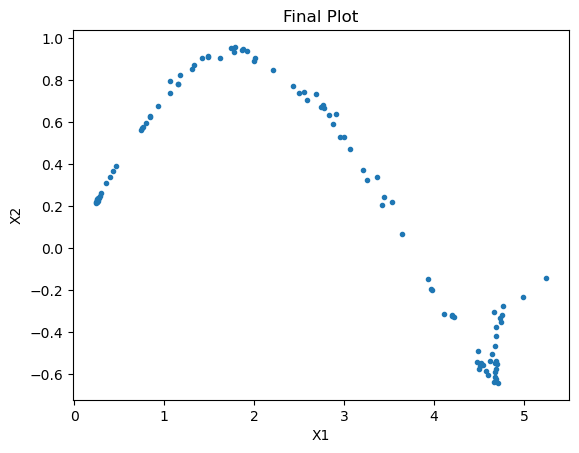

In [18]:
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Final Plot")

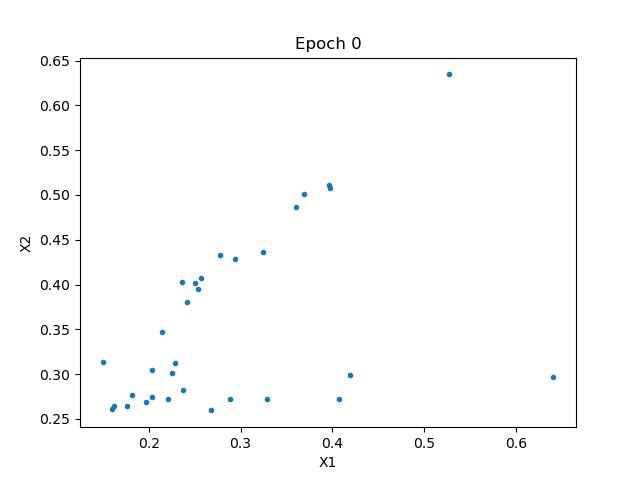

In [19]:
# Visualización del progreso de entrenamiento
# Para que esto se ve bien, por favor reinicien el kernel y corran todo el notebook

from PIL import Image
from IPython.display import display, Image as IPImage

images = [Image.open(path) for path in list_images]

# Save the images as an animated GIF
gif_path = "animation_pt1.gif"  # Specify the path for the GIF file
images[0].save(gif_path, save_all=True, append_images=images[1:], loop=0, duration=300)
display(IPImage(filename=gif_path))

*Las respuestas de estas preguntas representan el 10% de este notebook*

**PREGUNTAS:**
* Describa en una frase la diferencia entre los modelos discriminativos y los generativos
* Explique como el concepto de MinMax se aplica a los GAN
* Describa lo que se está observando en la imagen GIF que se generó
* ¿Cree que se ha creado un buen modelo? ¿Por qué?

In [20]:

print()
print("La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio")
tick.summarise_marks() # 


La fraccion de abajo muestra su rendimiento basado en las partes visibles de este laboratorio
